In [1]:
using LinearAlgebra
using FFTW
using Plots
using BenchmarkTools
using OrdinaryDiffEq

include("../../code/TaylorFourier.jl");



# The main problem of artificial satellite theory (in Stiefel-Scheifele VOP formulation)

Written as a system of ODEs for a fictitious time $\tau$ (with the physical time $t$ as an additional state variable):

\begin{equation}
\begin{split}
\frac{d}{d\tau} q &= r \, v, \quad q(0) = q_0,\\
\frac{d}{d\tau} v &= -\frac{\mu}{r^2} q -  r\, \nabla V(q), \quad v(0)=v_0\\
\frac{d}{d\tau} t &= r, \quad t(0) = t_0
\end{split}
\tag{1}
\end{equation}

where 

\begin{equation}
q_0 = \left(
\begin{matrix}
x_0\\
y_0\\
z_0
\end{matrix}
\right), \quad 
v_0 = \left(
\begin{matrix}
\dot x_0\\
\dot y_0\\
\dot z_0
\end{matrix}
\right), \quad r=\|q\|, 
%\quad h = \frac{1}{2} \langle v, v \rangle - \frac{\mu}{r} + V(q)
\end{equation}

and

\begin{equation}
V(q) =  \frac{C}{2\, r^3} \,\left(3\, \sin^2\theta -1 \right), \quad \sin\theta = \frac{z}{r}, \quad C=J_2\, \mu\, R_e^2.
\end{equation}

Constant parameters of the problem: $R_e = 6378.135 km$, $\mu=398600km^3/s^2$, $J_2=0.0010826157$.


The energy $\mathcal{E}(q,v):= \frac12 \, \langle v, v \rangle - \frac{\mu}{r} + V(q)$ is an invariant of the equations of motion. 
In addition, the $z$-component of the angular momentum
\begin{equation*}
x\, \dot y - \dot x\, y
\end{equation*}
is also a first integral.

In [2]:
function Energy(q,v,parms)
    μ = parms[1]
    C = parms[2]
    return 0.5*dot(v,v) - μ/norm(q)  +  V(q,parms)
end

function V(q,parms) 
    C = parms[2]
    z = q[3]
    r = norm(q)    
    sinth = z/r
    return C*(3*sinth^2-1)/(2*r^3)
end

function ZAngularMomentum(q,v) 
    return q[1]*v[2] - q[2]*v[1]
end

ZAngularMomentum (generic function with 1 method)

Following~\cite{Stiefel-Scheifele1971}, $q(\tau)$ and $t(\tau)$ in (1) can be obtained as follows: 

\begin{align*}
q(\tau) &= L(u(\tau))u(\tau), \quad v(\tau) = \frac{2}{\|u(\tau)\|^2}\, L(u(\tau)) u'(\tau), \\
\quad 
u(\tau) &=  \cos(\omega \tau) \alpha(\tau)+ \omega^{-1} \sin(\omega \tau) \beta(\tau), \quad
u'(\tau) =  -\omega\, \sin(\omega \tau) \alpha(\tau)+ \cos(\omega \tau) \beta(\tau),
\end{align*}

where

\begin{equation*}
\omega = \sqrt{-\frac12\, \mathcal{E}(q_0,v_0)}, \qquad
L({\bf u}) =
\left(
\begin{matrix}
u_1 & -u_2 & -u_3 & u_4 \\
u_2 & u_1 & -u_4 & -u_3 \\
u_3 & u_4 & u_1 & u_2 \\
%u_4 & -u_3 & u_2 & -u_1
\end{matrix}
\right),
\end{equation*}

and $(\alpha(\tau),\beta(\tau),t(\tau))$ is the solution of the 8-dimensional ODE system

\begin{equation}
\begin{split}
\frac{d}{d\tau}\alpha &=  \omega^{-1} \sin(\omega \tau) \nabla R( \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta),  \quad \alpha(0)=u_0,\\
\frac{d}{d\tau} \beta &= -\cos(\omega \tau)  \nabla R( \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta), \quad \beta(0)=w_0,\\
\frac{d}{d\tau} t &= \| \cos(\omega \tau) \alpha+ \omega^{-1} \sin(\omega \tau) \beta\|^2, \quad t(0) = t_0.
\end{split}
\tag{2}
\end{equation}


Here, $R(u) = \frac14\,  \|u\|^2\, V(L(u) u)$, that is,

\begin{equation*}
R(u) = \frac{1}{8\, r^2} \,\left(3\, (\sin(\theta))^2 -1 \right),
\end{equation*}

where  $r = u_1^2+u_2^2+u_3^2+u_4^2$ and
$\sin(\theta) = 2\,(u_1 u_3 + u_2 u_4)/r$. As for the vectors $u_0, w_0 \in \mathbb{R}^2$,

- $u_0 \in \mathbb{R}^4$ is chosen in such a way that 
\begin{equation*}
q_0 = L(u_0) u_0, 
\end{equation*}

- $w_0\in \mathbb{R}^4$ is determined as 
\begin{equation*}
w_0 = \frac12\, L(u_0)^T \, \dot q_0.
\end{equation*}

Obviously, there are infinitely many vectors $u_0$ that satisfy $q_0 = L(u_0) u_0$. The function $\chi(q)$ implemented below computes one of them. 

In [3]:
function χ(q)
    x = q[1]
    y = q[2]
    z = q[3]
    r = sqrt(x^2+y^2+z^2)
    if x >= 0
        aux = r + x
        u1 = 0.5*sqrt(aux)
        u4 = u1
        u2 = (y*u1 + z*u4)/aux
        u3 = (z*u1 - y*u4)/aux
    else
        aux = r - x
        u2 = 0.5*sqrt(aux)
        u3 = u2
        u1 = (y*u2 + z*u3)/aux
        u4 = (z*u2 - y*u3)/aux
    end
    return [u1, u2, u3, u4]
end

L(u) = [u[1] -u[2] -u[3]  u[4]
     u[2]  u[1] -u[4] -u[3]
     u[3]  u[4]  u[1]  u[2] ];

In [4]:
function qfromU(U, τ, parms)
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)
    α = U[1:4]
    β = U[5:8]
    u = c * α + (s/ω) * β
    q = L(u)*u
    return q
end


function vfromU(U, τ, parms)
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)
    α = U[1:4]
    β = U[5:8]
    u = c * α + (s/ω) * β
    r = dot(u,u)
    w = -ω * s * α + c * β
    v = 2/r*L(u)*w
    return v
end

vfromU (generic function with 1 method)

Let us check it for a randomly chosen $q_0$:

In [5]:
q0 = rand(3)
u0 = χ(q0)
norm(q0 - L(u0)*u0)

0.0

In [6]:
v0 = rand(3)
w0 = 0.5*(L(u0)')*v0
norm(2/dot(u0,u0)*L(u0)*w0 - v0)

5.551115123125783e-17

## Numerical solution with 9th order explicit RK method (Vern9)

We next implement in an efficient way the system of ODEs defined in (2).

In [7]:

function fODE!(dU, U, parms, τ) 
    # Efficient implementation of  the differential equations for (α, β, t)
    # α = U[1:4],  dα/dτ = dU[1:4]
    # β = U[5:8],  dβ/dτ = dU[5:8]
    # t = U[9],    dt/dτ = dU[9]
    C = parms[2]
    ω = parms[3]
    θ = ω*τ
    c = cos(θ)
    s = sin(θ)/ω
    #u = c * α + s * β
    u1 = c * U[1] + s * U[5]
    u2 = c * U[2] + s * U[6]
    u3 = c * U[3] + s * U[7]
    u4 = c * U[4] + s * U[8]
    z = 2*(u1*u3 + u2*u4)
    r = u1^2 + u2^2 + u3^2 + u4^2
    w = 1/r^3
    sth = z/r
    A = 0.5*C*w*(1 - 6*sth^2)
    B = 1.5*C*w*sth
    gradR1 = A*u1+B*u3
    gradR2 = A*u2+B*u4
    gradR3 = A*u3+B*u1
    gradR4 = A*u4+B*u2
    dU[1] = s*gradR1
    dU[2] = s*gradR2
    dU[3] = s*gradR3
    dU[4] = s*gradR4
    dU[5] = -c*gradR1
    dU[6] = -c*gradR2
    dU[7] = -c*gradR3
    dU[8] = -c*gradR4
    dU[9] = r
    return nothing
end

fODE! (generic function with 1 method)

## Geostationary orbit

We now consider the initial state of a Geostationary satellite (Montenbruck 2000, pg. 116) and solve (2) numerically with an explicit RK method of order 9 due to Verner.

In [8]:
μ = 398600.8
R_e = 6378.135
ϵ = 0.0010826157
C = μ * R_e^2 * ϵ
#q0 = [0., 37947.73745727695, 0.]
#v0 = [3.297676220718193,0., 0.8244190551795483]
# Geostationary satellite (Montenbruck pg. 116)
q0 = [4.21491336e4,0.0,0.0]                            # km
v0 = [0.0, 3.075823259987749,0.0010736649055318406 ]   # km/s


ω = sqrt(-Energy(q0,v0,[μ,C])/2)

u0 = χ(q0)
w0 = 0.5*(L(u0)') * v0

α0  = u0
β0  = w0
orbit_period = 2*π/ω

t0 = 0.
n_orbits = 400
tspan = (t0,t0+n_orbits*orbit_period)
U0 = [α0; β0; t0]

parms = [μ,C,ω]

prob = ODEProblem(fODE!, U0, tspan, parms);


M = 8
times = range(tspan[1],tspan[2],length=Int64(n_orbits*2M)+1)

tol = 1e-13
#@time sol = solve(prob, Vern9(), abstol=tol, reltol=tol,saveat=times);

In [9]:
orbit_period

4.087110716109999

In [10]:
E0 = Energy(q0,v0,parms)

-4.72668790298803

Let us check the errors in the conservarion of energy and the z component of the angular momemtum.

E0 = Energy(q0,v0,parms)
qq = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol.u, sol.t)
vv = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol.u, sol.t)
tt = [U[9] for U in sol.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq, vv)



pl1 = plot(title="Relative errors in energy", xlabel="t")
plot!(pl1, tt, Eerrs,label="Vern9, tol=1e-13")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq, vv)

pl2 = plot(title="Relative errors in z component \n of angular momentum", xlabel="t")
plot!(pl2, tt, Aerrs,label="Vern9, tol=1e-13")

plot(pl1,pl2, layout=(2,1), size=(500,300))

## Reference solution
### Global errors in positions ($q$) and physical time ($t$)

In order to estimate the global errors in $q$ and $t$ of the approximations that we will obtain with the Taylor-Fourier serie, we will compute a "exact" numerical approximation with high precision: tol=1e-20, and higher precision arithmetic (BigFloat).

In [11]:
prob_BF = ODEProblem(fODE!, BigFloat.(U0), BigFloat.(tspan), BigFloat.(parms));

sol_ex = solve(prob_BF, Vern9(), abstol=1e-20, reltol=1e-20,saveat=times);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/joseba/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


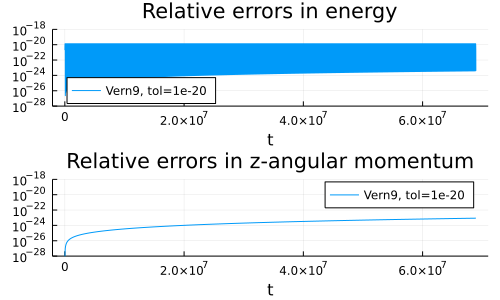

In [12]:
qq_ex = map((U,τ) -> qfromU(U,τ,parms), sol_ex.u, sol_ex.t)
vv_ex = map((U,τ) -> vfromU(U,τ,parms), sol_ex.u, sol_ex.t)
tt_ex = [U[9] for U in sol_ex.u]
EE_ex = map((q,v) -> abs(Energy(q,v,parms)), qq_ex, vv_ex)
Eerrs_ex = abs.(EE_ex ./ EE_ex[1] .- 1)   
AA_ex = map((q,v) -> abs(ZAngularMomentum(q,v)), qq_ex, vv_ex)
Aerrs_ex = abs.(AA_ex ./ AA_ex[1] .- 1) 


pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl1, tt_ex,Eerrs_ex,label="Vern9, tol=1e-20", legend=:bottomleft)


pl2 = plot(title="Relative errors in z-angular momentum", xlabel="t", yscale=:log10, ylims=(1e-28,1e-18))
plot!(pl2, tt_ex,Aerrs_ex,label="Vern9, tol=1e-20")

plot(pl1,pl2, layout=(2,1), size=(500,300))

errors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol.u, sol_ex.u) .+ eps(0.01)

pl1 = plot(tt_ex, errors, title="Relative errors in α and β", label="Vern9, tol=$tol", 
    yscale=:log10, ylims=(1e-17,1e-14),xlabel="t", legend=:bottomright);

qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)
pl2 = plot(title="Relative errors in q(t)", xlabel="t", 
           yscale=:log10, ylims=(1e-18,1e-12),legend=false)
plot!(pl2, tt_ex, qerrs,  label="Vern9, tol=1e-13", legend=:bottomright)

plot(pl1, pl2, layout = (2,1), size=(500,300))

terrs = norm.(tt-tt_ex) 
pl_time_RK = plot(xlabel="t")#, title="Absolute errors in physical time")
plot!(pl_time_RK, tt_ex[2:end], abs.(terrs[2:end]),  label="Vern9, tol=1e-13", 
     yscale=:log10, ylims=(1e-12,1e-6),legend=false, size=(600,200))

## Taylor-Fourier integration

We next compute the approximation of the above with our Taylor-Fourier serie

In [13]:
include("J2_VOP_ODE_TF.jl")  # include the functions that define the ODE as required by 
                             # our TaylorFourier integrator

J2_VOP_cache_init (generic function with 1 method)

In [14]:
n_orbits=400

400

In [15]:
deg = 8
M=8
tf_cache = J2_VOP_cache_init(U0,parms,ω,deg,M)
prob_TF = PeriodicODEProblem(TF_ODE!, tf_cache, U0, ω)
sol_TF = TaylorFourierSolve(prob_TF,deg,M,n_orbits);

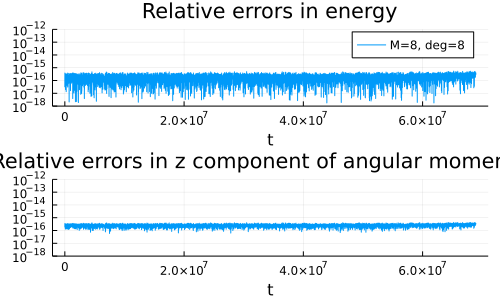

In [16]:
E0 = Energy(q0,v0,parms)
qq_TF = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
vv_TF = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
tt_TF = [U[9] for U in sol_TF.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF, vv_TF) .+ eps(0.01)



pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-18,1e-12))
plot!(pl1, tt_TF, Eerrs,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq_TF, vv_TF) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-12),legend=false)
plot!(pl2, tt_TF, Aerrs,label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

savefig(pl1, "error_energy.pdf")

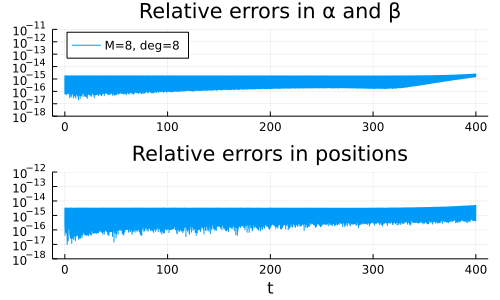

In [17]:
aberrors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol_TF.u, sol_ex.u)

pl1 = plot(sol_ex.t/orbit_period, aberrors, title="Relative errors in α and β", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-11), legend=:topleft);

qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(title="Relative errors in positions", xlabel="t", yscale=:log10, 
    ylims=(1e-18,1e-12), legend=false)
plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

plot(pl1, pl2, layout = (2,1), size=(500,300))




qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-12),legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="Vern9, tol=1e-13")

terrs = norm.(tt-tt_ex) .+ eps(0.01)
pl2 = plot(yscale=:log10, ylims=(1e-12,1e-6), legend=:bottomright)
plot!(pl2, sol_ex.t/orbit_period, terrs,  label="Vern9, tol=1e-13")

pl_pos = plot(pl1, pl2, layout = (2,1), size=(500,300))

#savefig(pl_pos, "position_errors.pdf")

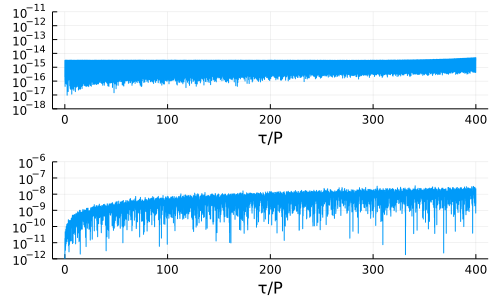

In [18]:


qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl1 = plot(xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-11),legend=false)

plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")


terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(xlabel="τ/P",
               yscale=:log10, ylims=(1e-12,1e-6), legend=false)
plot!(pl2, sol_ex.t/orbit_period, terrs,  label="M=$M, deg=$deg")

pl_time = plot(pl1,pl2, layout=(2,1), size=(500,300))

In [19]:
savefig(pl_time, "positions_and_time_errors.pdf")

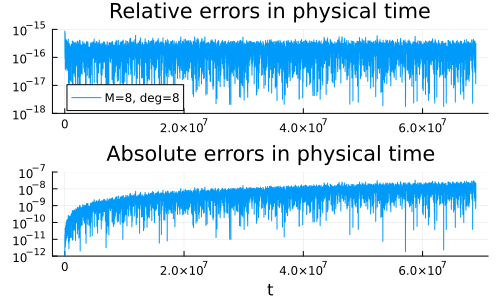

In [23]:
t_rel_errs =  abs.(tt_TF-tt_ex) ./ abs.(tt_ex) .+ eps(0.01)
pl1 = plot(tt_ex, t_rel_errs, title="Relative errors in physical time",  
          label="M=$M, deg=$deg", 
              yscale=:log10, ylims=(1e-18,1e-15), legend=:bottomleft);

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(title="Absolute errors in physical time", xlabel="t",
               yscale=:log10, ylims=(1e-12,1e-7), legend=:false)
plot!(pl2, tt_ex, terrs,  label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

In [ ]:
# @btime solve(prob, Vern9(), abstol=1e-13, reltol=1e-13,saveat=times)
# @btime TaylorFourierSolve(prob_TF,deg,M,n_orbits);
# output:
# 55.749 ms (146505 allocations: 18.49 MiB)
#  1.955 ms (12900 allocations: 1.90 MiB)
# relation: 
# 55.7/1.955 = 28.491048593350385
# In this example, our TaylorFourier integrator gives more precision with 28 times less CPU time.


## Averaging

We will approximate $Y(wt,t;y_0)$ with the value $Y_n(wt,0;Y(0,t;y_0))$ and We want to see if the approximation is good enough (or how good it is).

So, first we have to compute  
\begin{equation}
Y(0,t;y_0)
\end{equation}
and for this we have the function evaluatein_0theta_t().

Second, With this initial value we will compute  the corresponding TaylorFourier expression.
\begin{equation}
Y_n(wt,t;Y(0,t;y_0))
\end{equation}
We use the function TaylorFourierGen to generate the TaylorFourier series.

And third, we evaluate for the corresponding $t$ value the $Y_n$ TayloFourier serie  
\begin{equation}
Y_n(wt,0;Y(0,t;y_0))
\end{equation}
and so, we can compare it with $Y(wt,t;y_0)$.

The $t$ values  wil be the same values computed in TaylorFourierSolve process. 

In [21]:

# evaluation with horner method applied to the polynomial and to the Fourier serie
# the evaluation is made for theta = 0 so it evaluates just a polynomial for the corresponding t
function evaluatein_0theta_t(ms::TaylorFourierSeries{Float64,Float64},t::Number)  #y(t)--> y(0theta,t) 
    M = ms.M
    TwoMinv=0.5/M
    wdegree = ms.working_degree[]
    #omega = ms.omega  #  2*pi/P
    #theta = omega*t
    theta=0
    number_of_vars = ms.num_vars
    x=exp(im*theta)
    ret_v = Array{Float64}(undef,number_of_vars)
    @inbounds for  elem in 1:number_of_vars
        ret_v[elem]= real(ms.coeffs[1,elem,wdegree+1])  # the last element of the polynomial has constant coefficient
    end
    @inbounds for g in wdegree:-1:1 
        for elem in 1:number_of_vars
            ret_v[elem] *= t  
            xpart= ms.coeffs[M+1,elem,g]*x # initialize with the last element (with not 2*).
            for k in M:-1:2
                xpart= (xpart + 2.0*ms.coeffs[k,elem,g])*x
            end
            ret_v[elem] += real(ms.coeffs[1,elem,g]+xpart)
        end
    end
    @inbounds for  elem in 1:number_of_vars
        ret_v[elem] *=TwoMinv
    end
    return ret_v
end

evaluatein_0theta_t (generic function with 1 method)

In [22]:
# evaluation with horner method applied to the polynomial and to the Fourier serie
# the evaluation is made for theta = omega*t the result is y(omega*t, 0)
# that is, evaluates a fourier serie (as t=0 all the polinomials are constant values)
function evaluatein_theta_0t(ms::TaylorFourierSeries{Float64,Float64},t::Number)  #y(t)--> y(theta,0t) 
    M = ms.M
    TwoMinv=0.5/M
    wdegree = ms.working_degree[]
    omega = ms.omega  #  2*pi/P
    theta = omega*t
    t=0
    number_of_vars = ms.num_vars
    x=exp(im*theta)
    ret_v = Array{Float64}(undef,number_of_vars)
    #@inbounds for  elem in 1:number_of_vars 
    #    # the last element of the polynomial has constant coefficient
    #    ret_v[elem]= real(ms.coeffs[1,elem,wdegree+1]) end
    #only the independent term of the polinomial part has sense. The rest (t^g) are 0
    #@inbounds for g in wdegree:-1:1 
    g=1
        for elem in 1:number_of_vars
            #ret_v[elem] *= t  
            ret_v[elem] = 0  
            xpart= ms.coeffs[M+1,elem,g]*x # initialize with the last element (with not 2*).
            for k in M:-1:2
                xpart= (xpart + 2.0*ms.coeffs[k,elem,g])*x
            end
            ret_v[elem] += real(ms.coeffs[1,elem,g]+xpart)
        end
    # end we do not need the for of the polinomials
    @inbounds for  elem in 1:number_of_vars
        ret_v[elem] *=TwoMinv
    end
    return ret_v
end

evaluatein_theta_0t (generic function with 1 method)

We need the function that generates just the TaylorFourier series, (TaylorFrourierSolve function computes it, but we do not need the evaluation of the series at many points in the period, so it is a similar function, but without the discrete solution computation).

In [23]:

function TaylorFourierGen(prob::PeriodicODEProblem{ueltype,Float64,pType}, max_degree::Int64,m::Int64) where {ueltype,pType}
    u0 = prob.u0
    msa=TaylorFourierSeries(u0, prob.omega, max_degree, m)
    msb=TaylorFourierSeries(u0, prob.omega, max_degree, m)
    TaylorFourierSeries_init!(msa,prob) # gets initial Taylor-series
    for w_degree in 1:max_degree 
       prob.funct!(msb,msa,prob.params)  # evaluate the Differential Equation at each point in the period
                                          # generate the Taylor series of f(msa)
       msb.working_degree[] = msa.working_degree[]
       interpolate_T_coeffs_by_Fourier!(msb) # get the interpolating Fourier series for all 
                                                       # coefficients of each degree of the Taylor series
       integrate!(msa, msb, u0) # integrate and increase order 
       mod_serie2taylor_series!(msa)  # Get the Taylor-series from the new modulated-series
    end
    return msa
end
 

TaylorFourierGen (generic function with 1 method)

And lastly, the function that makes the proccess for all the $t$ values of the discrete solution  obtained by TaylorFourierSolve

In [24]:
# for each t obtained in the discretized solution of the problem we will obtain its approximation in this way:
#   first obtain the TaylorFourier value for theta = 0 and the value of t (this is suposed to be an approximation of the 
#      of the estroboscopic solution for the given t, in fact it corresponds to the evaluation of one 
#      polinomial on t)
#   second obtain the taylor-fourier approximation of the problem with initial value equal to the
#      approximation value obtained in the previous step
#   third evaluate the new taylorFourier expresion for theta =omega*t, but without advancing on t (this is the
#      evaluation of a periodic expresion; the fourier serie of the taylor fourier expresion corresponding
#      to the free coefficient)
function ApproxOfDiscreteSolution(sol::PeriodicODEProblemSolution{ueltype,Float64}) where {ueltype}
    #TwoM = 2*sol.TFS.M
    M = sol.TFS.M
    deg = sol.TFS.max_degree
    #deg=4
    #wdegree = sol.TFS.working_degree[1]
    #g = wdegree+1
    omega = sol.TFS.omega  #  2*pi/P ---> P = 2*pi/omega --> t= k*P/(2M)+(j-1)*P == k*pi/(omega*M)+(j-1)*P
    number_of_vars = sol.TFS.num_vars
    period = 2*π/omega
    n_outputs = length(sol.t)
    #tt = sol.t
    uu = Vector{Vector{ueltype}}(undef,n_outputs)
    for t_ind in 1:n_outputs
        t_new = sol.t[t_ind]
        U0_new = evaluatein_0theta_t(sol.TFS,sol.t[t_ind])
        tf_cache_new = J2_VOP_cache_init(U0_new,parms,omega,deg,M)
        prob_TF_new = PeriodicODEProblem(TF_ODE!, tf_cache_new, U0_new, omega)
        TFS_new = TaylorFourierGen(prob_TF_new,deg,M)
        uu[t_ind] = evaluatein_theta_0t(TFS_new, t_new)
    end
    #return tt,uu
    return uu
end

# The approximation can be made with different dimensions...

function ApproxOfDiscreteSolution(sol::PeriodicODEProblemSolution{ueltype,Float64},M::Int64,deg::Int64) where {ueltype}
    #TwoM = 2*sol.TFS.M
    #M = sol.TFS.M
    #deg = sol.TFS.max_degree
    #deg=4
    #wdegree = sol.TFS.working_degree[1]
    #g = wdegree+1
    omega = sol.TFS.omega  #  2*pi/P ---> P = 2*pi/omega --> t= k*P/(2M)+(j-1)*P == k*pi/(omega*M)+(j-1)*P
    number_of_vars = sol.TFS.num_vars
    period = 2*π/omega
    n_outputs = length(sol.t)
    #tt = sol.t
    uu = Vector{Vector{ueltype}}(undef,n_outputs)
    for t_ind in 1:n_outputs
        t_new = sol.t[t_ind]
        U0_new = evaluatein_0theta_t(sol.TFS,sol.t[t_ind])
        tf_cache_new = J2_VOP_cache_init(U0_new,parms,omega,deg,M)
        prob_TF_new = PeriodicODEProblem(TF_ODE!, tf_cache_new, U0_new, omega)
        TFS_new = TaylorFourierGen(prob_TF_new,deg,M)
        uu[t_ind] = evaluatein_theta_0t(TFS_new, t_new)
    end
    #return tt,uu
    return uu
end
    

ApproxOfDiscreteSolution (generic function with 2 methods)

### set the number of ofbits and get the corresponding Taylor-Fourier solution

In [27]:
n_orbits = 600
deg = 8
M=8
tf_cache = J2_VOP_cache_init(U0,parms,ω,deg,M)
prob_TF = PeriodicODEProblem(TF_ODE!, tf_cache, U0, ω)
sol_TF = TaylorFourierSolve(prob_TF,deg,M,n_orbits)
E0 = Energy(q0,v0,parms)
# vectors of discrete approximations
qq_TF = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
vv_TF = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
tt_TF = [U[9] for U in sol_TF.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF, vv_TF) .+ eps(0.01);

### Get the "exact" solution (Vern9 method with tolerance = 10^-20 with bigFloat arithmetic) for the discrete approximation

In [30]:

tspan = (t0,t0+n_orbits*orbit_period)
times = range(tspan[1],tspan[2],length=Int64(n_orbits*2M)+1)
prob_BF = ODEProblem(fODE!, BigFloat.(U0), BigFloat.(tspan), BigFloat.(parms));
sol_ex = solve(prob_BF, Vern9(), abstol=1e-20, reltol=1e-20,saveat=times);
qq_ex = map((U,τ) -> qfromU(U,τ,parms), sol_ex.u, sol_ex.t)
vv_ex = map((U,τ) -> vfromU(U,τ,parms), sol_ex.u, sol_ex.t)
tt_ex = [U[9] for U in sol_ex.u]
#EE_ex = map((q,v) -> abs(Energy(q,v,parms)), qq_ex, vv_ex)
#Eerrs_ex = abs.(EE_ex ./ EE_ex[1] .- 1)   
#AA_ex = map((q,v) -> abs(ZAngularMomentum(q,v)), qq_ex, vv_ex)
#Aerrs_ex = abs.(AA_ex ./ AA_ex[1] .- 1) 
orbit_period

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/joseba/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


4.087110716109999

### Call to the function that computes the approximations

In [31]:
approxu = ApproxOfDiscreteSolution(sol_TF)
# we can aproximate using Taylor-Fourier series with different dimensions in M or d
# approxu = ApproxOfDiscreteSolution(sol_TF,8,8);

qq_TF_approx = map((U,τ) -> qfromU(U,BigFloat(τ),parms), approxu, sol_TF.t)
vv_TF_approx = map((U,τ) -> vfromU(U,BigFloat(τ),parms), approxu, sol_TF.t)
tt_TF_approx = [U[9] for U in approxu]
Eerrs_approx = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF_approx, vv_TF_approx) .+ eps(0.01);

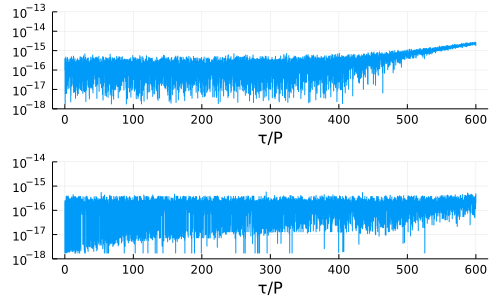

In [32]:

# compare TF and the approximation of TF

pl1 = plot( xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-13),legend=false)
plot!(pl1, sol_TF.t/orbit_period, Eerrs_approx,label="M=$M, deg=$deg")


errs = norm.(qq_TF_approx-qq_TF) ./ norm.(qq_TF) .+ eps(0.01)

pl2 = plot(yscale=:log10, ylims=(1e-18,1e-14),legend=false)
plot!(pl2, sol_TF.t/orbit_period, errs, xlabel="τ/P",  label="relative: M=$M, deg=$deg")

pl_promediatua=plot(pl1, pl2, layout = (2,1), size=(500,300))

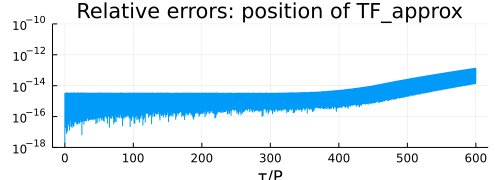

In [38]:

qerrs = norm.(qq_TF_approx-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl0 = plot(yscale=:log10, ylims=(1e-18,1e-10),size=(500,180),legend=false,xlabel="τ/P", title="Relative errors: position of TF_approx",)
plot!(pl0, sol_TF.t/orbit_period, qerrs,  label="relative: M=$M, deg=$deg")



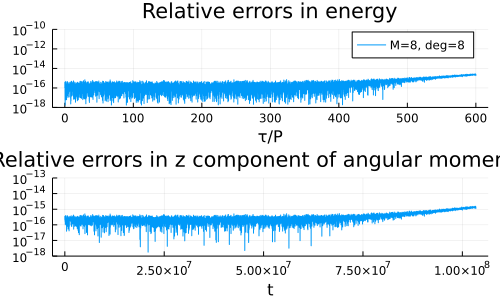

In [32]:




pl1 = plot(title="Relative errors in energy", xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-10))
plot!(pl1, sol_TF.t/orbit_period, Eerrs_approx,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs_approx = map((q,v) -> abs(ZAngularMomentum(q,v) / A0 - 1), qq_TF_approx, vv_TF_approx) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-13),legend=false)
plot!(pl2, tt_TF_approx, Aerrs_approx,label="M=$M, deg=$deg")

#plot(Eerrs_approx)
pl_error=plot(pl1,pl2, layout=(2,1), size=(500,300))

In [35]:
filename ="approx_errors_"*string(n_orbits)*".pdf"

"approx_errors_400.pdf"

In [ ]:
savefig(pl_error, filename)

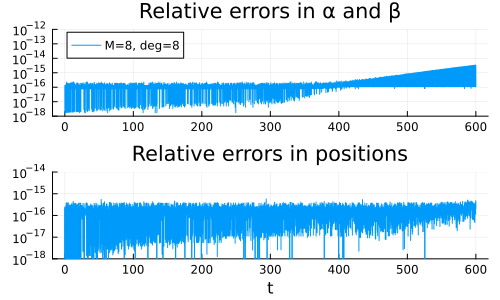

In [173]:
aberrors = map((u,u_tf) -> norm(u[1:8]-u_tf[1:8])/norm(u_tf[1:8]), approxu, sol_TF.u) .+ eps(0.01)

pl1 = plot(sol_TF.t/orbit_period, aberrors, title="Relative errors in α and β", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-12), legend=:topleft);

qerrs = norm.(qq_TF_approx-qq_TF) ./ norm.(qq_TF)
pl2 = plot(title="Relative errors in positions", xlabel="t", yscale=:log10, 
    ylims=(1e-18,1e-14), legend=false)
plot!(pl2, sol_TF.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

pl_pos_error=plot(pl1, pl2, layout = (2,1), size=(500,300))

In [37]:
filename ="approx_errors_pos"*string(n_orbits)*".pdf"

"approx_errors_pos400.pdf"

In [ ]:
savefig(pl_pos_error, filename)

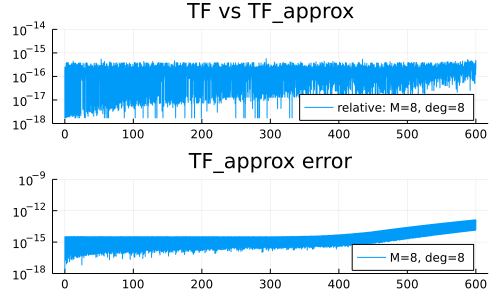

In [38]:

# compare TF and the approximation of TF

qerrs = norm.(qq_TF_approx-qq_TF) ./ norm.(qq_TF) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright,title="TF vs TF_approx",)
plot!(pl1, sol_TF.t/orbit_period, qerrs,  label="relative: M=$M, deg=$deg")

qerrs =  norm.(qq_TF_approx-qq_ex)./ norm.(qq_ex).+ eps(0.01)

pl2 = plot(sol_TF.t/orbit_period, qerrs, title="TF_approx error", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-9), legend=:bottomright);

pl_q_errors=plot(pl1, pl2, layout = (2,1), size=(500,300))

In [42]:
filename ="pos_error_TFvsApprox_"*string(n_orbits)*".pdf"

"pos_error_TFvsApprox_400.pdf"

In [44]:
savefig(pl_q_errors, filename)

"/home/joseba/ownCloud/ik/2023-TF/artikulurako/artikuluko-github/examples/Promediatua/pos_error_TFvsApprox_400.pdf"

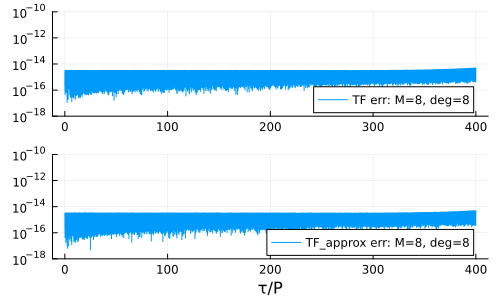

In [40]:


qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-10),legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="TF err: M=$M, deg=$deg")



qerrs = norm.(qq_TF_approx-qq_ex) ./ norm.(qq_ex)
pl2 = plot(xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-10),legend=:bottomright)

plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="TF_approx err: M=$M, deg=$deg")

pl_pos = plot(pl1, pl2, layout = (2,1), size=(500,300))

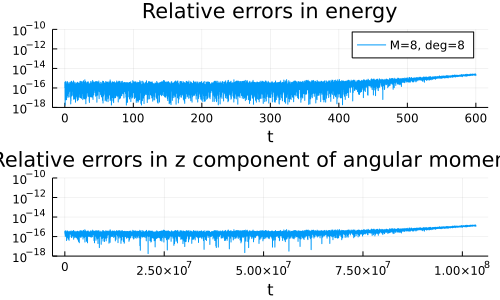

In [34]:

pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-18,1e-10))
plot!(pl1, sol_TF.t/orbit_period, Eerrs_approx,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs_approx = map((q,v) -> abs(ZAngularMomentum(q,v) / A0 - 1), qq_TF_approx, vv_TF_approx) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-10),legend=false)
plot!(pl2, tt_TF_approx, Aerrs_approx,label="M=$M, deg=$deg")

#plot(Eerrs_approx)
pl_error=plot(pl1,pl2, layout=(2,1), size=(500,300))

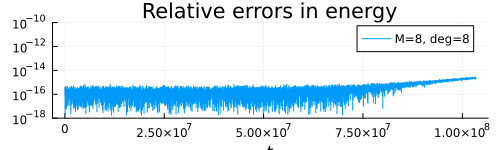

In [101]:
filename ="Energy_errors_TFapprox_"*string(n_orbits)*".pdf"
pl_error=plot(pl1,  size=(500,150))

In [98]:
savefig(pl_1_error, filename)

"/home/joseba/ownCloud/ik/2023-TF/artikulurako/artikuluko-github/examples/Promediatua/Z_and_E_errors_TFApprox_600.pdf"

In [52]:
savefig(pl_promediatua, "averaging_600.pdf")

## Highly eccentric orbit

### Numerical solution with 9th order explicit RK method (Vern9)

We now consider the initial state of a satellite with a highly eccentric orbit (Montenbruck 2000, pg. 51) and solve (2) numerically with an explicit RK method of order 9 due to Verner.

In [49]:
μ = 398600.8
R_e = 6378.135
ϵ = 0.0010826157
C = μ * R_e^2 * ϵ

# Highly eccentric orbit (Montenbruck pg. 51)

q0=[1.1959886901183693e7,-1.6289448826603336e7,-5.963757695165331e6]/1000
v0=[4724.300951633136,-1109.9935305609756,-384.7854410416176]/1000     



ω = sqrt(-Energy(q0,v0,[μ,C])/2)

u0 = χ(q0)
w0 = 0.5*(L(u0)') * v0

α0  = u0
β0  = w0
orbit_period = 2*π/ω

t0 = 0.
n_orbits = 40
tspan = (t0,t0+n_orbits*orbit_period)
U0 = [α0; β0; t0]

parms = [μ,C,ω]

prob = ODEProblem(fODE!, U0, tspan, parms);


M = 128
times = range(tspan[1],tspan[2],length=Int64(n_orbits*2M)+1)

tol = 1e-14

1.0e-14

Let us check the errors in the conservarion of energy and the z component of the angular momemtum.

### Reference solution for Global errors in positions ($q$) and physical time ($t$)

In order to estimate the global errors in q adn t of the numerical solution obtained above, we will compute a new numerical approximation with high precision: tol=1e-20, and higher precision arithmetic (BigFloat).

In [50]:
prob_BF = ODEProblem(fODE!, BigFloat.(U0), BigFloat.(tspan), BigFloat.(parms));

sol_ex = solve(prob_BF, Vern9(), abstol=1e-20, reltol=1e-20,saveat=times);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/joseba/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


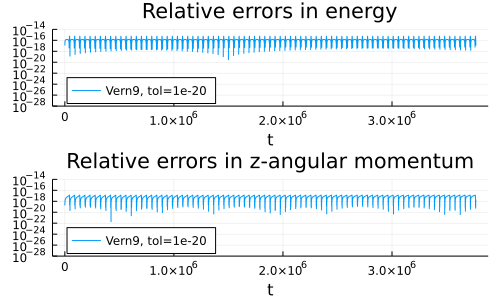

In [53]:
qq_ex = map((U,τ) -> qfromU(U,τ,parms), sol_ex.u, sol_ex.t)
vv_ex = map((U,τ) -> vfromU(U,τ,parms), sol_ex.u, sol_ex.t)
tt_ex = [U[9] for U in sol_ex.u]
EE_ex = map((q,v) -> abs(Energy(q,v,parms)), qq_ex, vv_ex)
Eerrs_ex = abs.(EE_ex ./ EE_ex[1] .- 1)   
AA_ex = map((q,v) -> abs(ZAngularMomentum(q,v)), qq_ex, vv_ex)
Aerrs_ex = abs.(AA_ex ./ AA_ex[1] .- 1) 


pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-28,1e-14))
plot!(pl1, tt_ex,Eerrs_ex,label="Vern9, tol=1e-20", legend=:bottomleft)


pl2 = plot(title="Relative errors in z-angular momentum", xlabel="t", yscale=:log10, ylims=(1e-28,1e-14))
plot!(pl2, tt_ex,Aerrs_ex,label="Vern9, tol=1e-20",legend=:bottomleft)

plot(pl1,pl2, layout=(2,1), size=(500,300))

sol = solve(prob, Vern9(), abstol=tol, reltol=tol,saveat=times);
#@time sol = solve(prob, Vern9(), abstol=tol, reltol=tol,saveat=times);
E0 = Energy(q0,v0,parms)
qq = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol.u, sol.t)
vv = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol.u, sol.t)
tt = [U[9] for U in sol.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq, vv)



pl1 = plot(title="Relative errors in energy", xlabel="t")
plot!(pl1, tt, Eerrs,label="Vern9, tol=1e-13")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq, vv)

pl2 = plot(title="Relative errors in z component \n of angular momentum", xlabel="t")
plot!(pl2, tt, Aerrs,label="Vern9, tol=1e-13")

plot(pl1,pl2, layout=(2,1), size=(500,300))

errors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol.u, sol_ex.u) .+ eps(0.01)

pl1 = plot(tt_ex, errors, title="Relative errors in α and β", label="Vern9, tol=$tol", 
    yscale=:log10, ylims=(1e-17,1e-14),xlabel="t", legend=:bottomright);

qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)
pl2 = plot(title="Relative errors in q(t)", xlabel="t", 
           yscale=:log10, ylims=(1e-18,1e-14),legend=false)
plot!(pl2, tt_ex, qerrs,  label="Vern9, tol=1e-13", legend=:bottomright)

plot(pl1, pl2, layout = (2,1), size=(500,300))

terrs = norm.(tt-tt_ex) 
pl_time_RK = plot(xlabel="t")#, title="Absolute errors in physical time")
plot!(pl_time_RK, tt_ex[2:end], abs.(terrs[2:end]),  label="Vern9, tol=1e-13", 
     yscale=:log10, ylims=(1e-12,1e-6),legend=false, size=(600,200))

## Taylor-Fourier approximation

We next integrate the problem above with our Taylor-Fourier integrator

In [112]:
include("J2_VOP_ODE_TF.jl")  # include the functions that define the ODE as required by 
                             # our TaylorFourier integrator

J2_VOP_cache_init (generic function with 1 method)

In [54]:
deg = 14
tf_cache = J2_VOP_cache_init(U0,parms,ω,deg,M)
prob_TF = PeriodicODEProblem(TF_ODE!, tf_cache, U0, ω)
sol_TF = TaylorFourierSolve(prob_TF,deg,M,n_orbits);
E0 = Energy(q0,v0,parms)
qq_TF = map((U,τ) -> qfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
vv_TF = map((U,τ) -> vfromU(U,BigFloat(τ),parms), sol_TF.u, sol_TF.t)
tt_TF = [U[9] for U in sol_TF.u]
Eerrs = map((q,v) -> abs(Energy(q,v,parms) / E0 - 1), qq_TF, vv_TF) .+ eps(0.01);

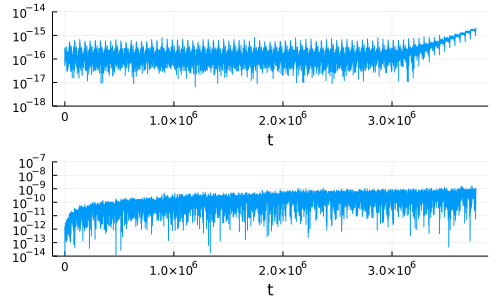

In [55]:



qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl1 = plot(xlabel="t", yscale=:log10, ylims=(1e-18,1e-14), legend=false)
plot!(pl1, tt_ex, qerrs,  label="M=$M, deg=$deg")


terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(xlabel="t",
               yscale=:log10, ylims=(1e-14,1e-7), legend=:false)
plot!(pl2, tt_ex, terrs,  label="M=$M, deg=$deg")

pl_ecc=plot(pl1,pl2, layout=(2,1), size=(500,300))

In [56]:
savefig(pl_ecc, "error_pos_rel_and_abs_t_ecc.pdf")

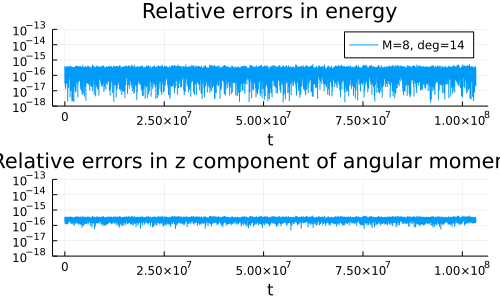

In [47]:

pl1 = plot(title="Relative errors in energy", xlabel="t", yscale=:log10, ylims=(1e-18,1e-13))
plot!(pl1, tt_TF, Eerrs,label="M=$M, deg=$deg")

A0 = ZAngularMomentum(q0,v0)
Aerrs = map((q,v) -> ZAngularMomentum(q,v) / A0 - 1, qq_TF, vv_TF) .+ eps(0.01)

pl2 = plot(title="Relative errors in z component of angular momentum", xlabel="t", 
                 yscale=:log10, ylims=(1e-18,1e-13),legend=false)
plot!(pl2, tt_TF, Aerrs,label="M=$M, deg=$deg")

plot(pl1,pl2, layout=(2,1), size=(500,300))

In [172]:
savefig(pl1, "error_energy.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/error_energy.pdf"

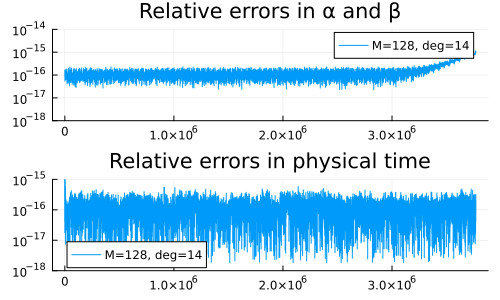

In [124]:
aberrors = map((u,u_ex) -> norm(u[1:8]-u_ex[1:8])/norm(u_ex[1:8]), sol_TF.u, sol_ex.u)

pl1 = plot(tt_ex, aberrors, title="Relative errors in α and β", label="M=$M, deg=$deg", 
             yscale=:log10, ylims=(1e-18,1e-14));

t_rel_errs =  abs.(tt_TF-tt_ex) ./ abs.(tt_ex) .+ eps(0.01)
pl2 = plot(tt_ex, t_rel_errs, title="Relative errors in physical time",  label="M=$M, deg=$deg", 
              yscale=:log10, ylims=(1e-18,1e-15), legend=:bottomleft);

plot(pl1, pl2, layout = (2,1), size=(500,300))

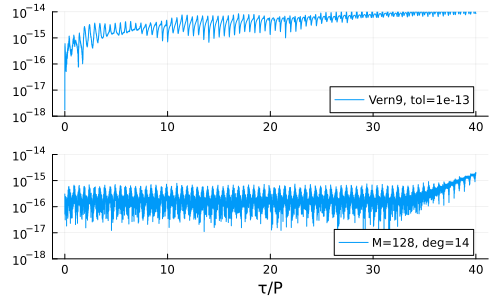

In [175]:



qerrs = norm.(qq-qq_ex) ./ norm.(qq_ex) .+ eps(0.01)

pl1 = plot(yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, qerrs,  label="Vern9, tol=1e-13")



qerrs = norm.(qq_TF-qq_ex) ./ norm.(qq_ex)
pl2 = plot(xlabel="τ/P", yscale=:log10, ylims=(1e-18,1e-14),legend=:bottomright)

plot!(pl2, sol_ex.t/orbit_period, qerrs,  label="M=$M, deg=$deg")

pl_pos = plot(pl1, pl2, layout = (2,1), size=(500,300))

In [176]:
savefig(pl_pos, "position_errors_ecc.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/position_errors_ecc.pdf"

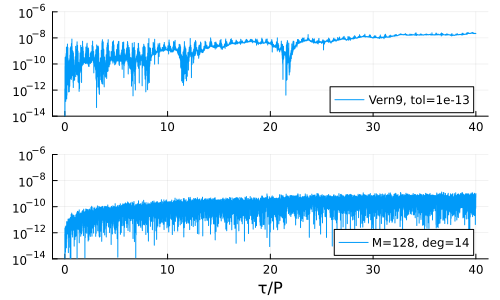

In [177]:
terrs = norm.(tt-tt_ex) .+ eps(0.01)
pl1 = plot(yscale=:log10, ylims=(1e-14,1e-6), legend=:bottomright)
plot!(pl1, sol_ex.t/orbit_period, terrs,  label="Vern9, tol=1e-13")

terrs = norm.(tt_TF-tt_ex) .+ eps(0.01)
pl2 = plot(xlabel="τ/P",
               yscale=:log10, ylims=(1e-14,1e-6), legend=:bottomright)
plot!(pl2, sol_ex.t/orbit_period, terrs,  label="M=$M, deg=$deg")

pl_time = plot(pl1,pl2, layout=(2,1), size=(500,300))

In [178]:
savefig(pl_time, "time_errors_ecc.pdf")

"/Users/ander/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/J2_VOP/time_errors_ecc.pdf"

In [179]:
@time solve(prob, Vern9(), abstol=1e-13, reltol=1e-13,saveat=times)
@time TaylorFourierSolve(prob_TF,deg,M,n_orbits);

  0.008664 seconds (41.09 k allocations: 5.568 MiB)
  0.004696 seconds (11.05 k allocations: 6.479 MiB)


In [180]:
0.015659/0.007889

1.9849157054125997

In this example, our TaylorFourier integrator gives more precision with 2.6 times less CPU time.